In [1]:
# Autoencoder Test Notebook
# Test bf16 image autoencoders from brain_checkpoints

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Import the image encoder/decoder classes
from visual_transformer.model import ImageTransformerEncoder, ImageTransformerDecoder

# Import game for generating test images
from game import discreteGame, BIG_tool_use_advanced_2_5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using device: cuda:0


In [2]:
def quick_display(torch_img, title=None):
    """Helper to display a torch image (handles bf16)."""
    clean = torch_img.detach().cpu().float()  # Convert bf16 to float for display
    if len(clean.shape) == 4:
        clean = clean[0]  # Remove batch dim
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy().clip(0, 1)
    plt.imshow(array)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def compare_images(inp, out, titles=('Input', 'Output')):
    """Display input and output side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    for i, (img, title) in enumerate(zip([inp, out], titles)):
        clean = img.detach().cpu().float()
        if len(clean.shape) == 4:
            clean = clean[0]
        right_order = torch.permute(clean, (1, 2, 0))
        array = right_order.numpy().clip(0, 1)
        axes[i].imshow(array)
        axes[i].set_title(title)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [3]:
class ImageAutoencoder(nn.Module):
    """Simple wrapper combining encoder and decoder."""
    def __init__(self, embed_dim=1024, num_heads=8):
        super().__init__()
        self.img_enc = ImageTransformerEncoder(embed_dim=embed_dim, num_heads=num_heads)
        self.img_dec = ImageTransformerDecoder(embed_dim=embed_dim, num_heads=num_heads)
    
    def forward(self, x):
        encoded = self.img_enc(x)
        decoded = self.img_dec(encoded)
        return decoded

# Create autoencoder in bf16
autoencoder = ImageAutoencoder().to(device).to(torch.bfloat16)
print(f"Autoencoder created: {sum(p.numel() for p in autoencoder.parameters())} parameters")

Autoencoder created: 89411587 parameters


In [4]:
# Load first checkpoint: finetune_control_better_embeddings_bf16_step_000200.pt
CHECKPOINT_1 = 'brain_checkpoints/finetune_control_better_embeddings_bf16_step_000200.pt'

try:
    state_dict = torch.load(CHECKPOINT_1, map_location=device, weights_only=True)
    
    # Extract just the encoder/decoder weights
    enc_dec_state = {}
    for k, v in state_dict.items():
        if k.startswith('img_enc.'):
            enc_dec_state[k] = v
        elif k.startswith('img_dec.'):
            enc_dec_state[k] = v
    
    autoencoder.load_state_dict(enc_dec_state, strict=False)
    print(f"Loaded checkpoint 1: {CHECKPOINT_1}")
    print(f"  Keys loaded: {len(enc_dec_state)}")
except Exception as e:
    print(f"Error loading checkpoint 1: {e}")

Loaded checkpoint 1: brain_checkpoints/finetune_control_better_embeddings_bf16_step_000200.pt
  Keys loaded: 139


Testing checkpoint 1: finetune_control_better_embeddings_bf16

Sample 1 - MSE: 0.002902


[W206 14:11:08.165020962 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.
/home/atbolsh/anaconda3/envs/hf-decant/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


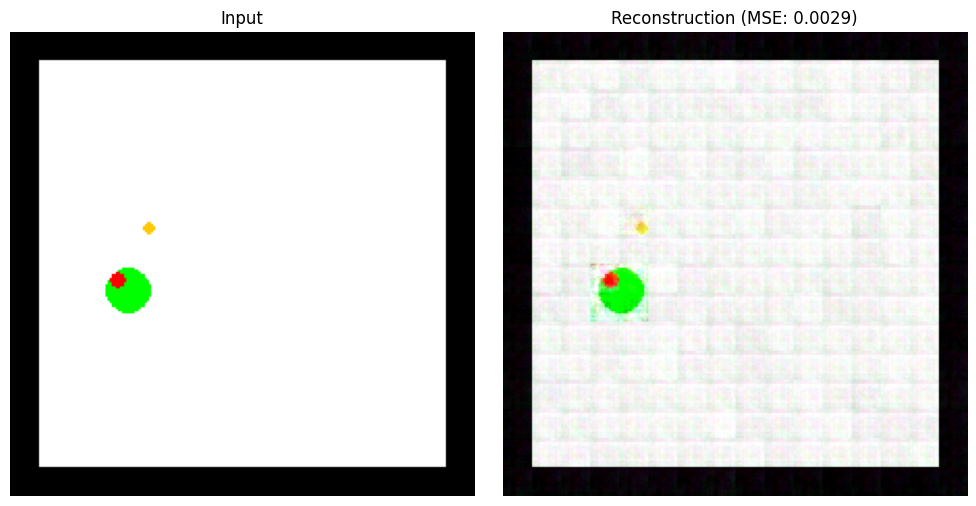


Sample 2 - MSE: 0.002911


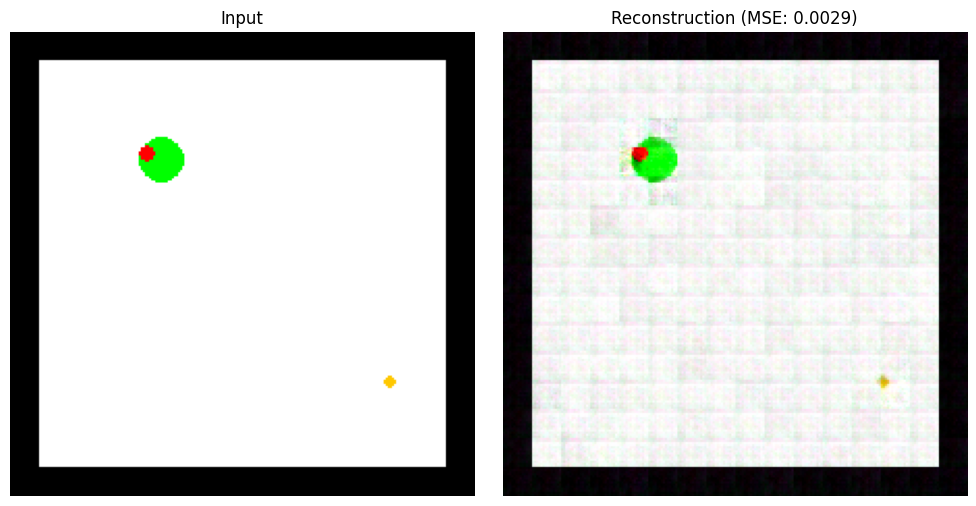


Sample 3 - MSE: 0.003041


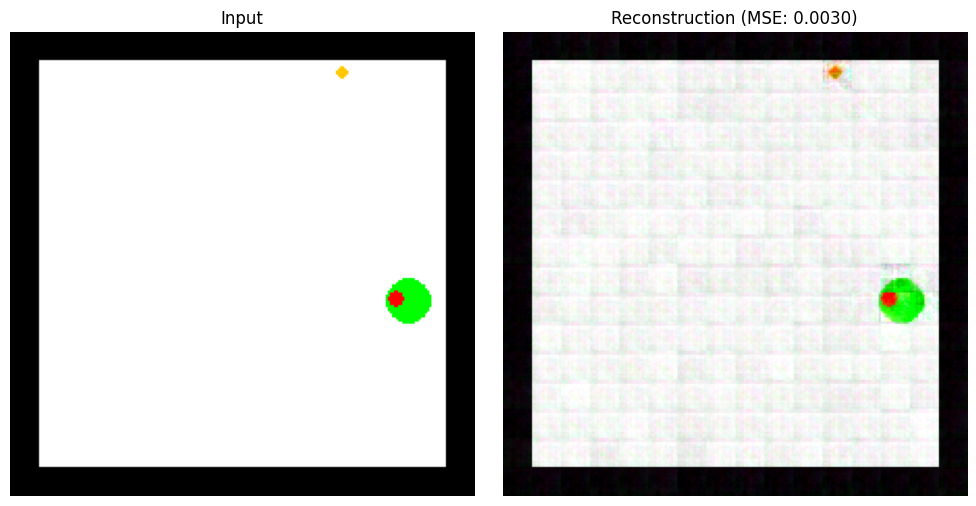

In [5]:
# Generate test images and run through autoencoder
print("Testing checkpoint 1: finetune_control_better_embeddings_bf16")

# Create a base game instance for generating random settings
base_game = discreteGame(BIG_tool_use_advanced_2_5)

# Generate a few test images
for i in range(3):
    G = discreteGame(base_game.random_bare_settings(gameSize=224, max_agent_offset=0.5))
    
    # Convert to tensor
    img = torch.tensor(G.getData(), dtype=torch.bfloat16).unsqueeze(0)
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    
    # Run through autoencoder
    with torch.no_grad():
        recon = autoencoder(img)
    
    # Compute reconstruction error
    mse = ((img.float() - recon.float()) ** 2).mean().item()
    
    print(f"\nSample {i+1} - MSE: {mse:.6f}")
    compare_images(img, recon, titles=('Input', f'Reconstruction (MSE: {mse:.4f})'))

In [6]:
# Load second checkpoint: naked_image_bf16_step_008000.pt
CHECKPOINT_2 = 'brain_checkpoints/naked_image_bf16_step_008000.pt'

# Create fresh autoencoder
autoencoder2 = ImageAutoencoder().to(device).to(torch.bfloat16)

try:
    state_dict = torch.load(CHECKPOINT_2, map_location=device, weights_only=True)
    
    # Extract just the encoder/decoder weights
    enc_dec_state = {}
    for k, v in state_dict.items():
        if k.startswith('img_enc.'):
            enc_dec_state[k] = v
        elif k.startswith('img_dec.'):
            enc_dec_state[k] = v
    
    autoencoder2.load_state_dict(enc_dec_state, strict=False)
    print(f"Loaded checkpoint 2: {CHECKPOINT_2}")
    print(f"  Keys loaded: {len(enc_dec_state)}")
except Exception as e:
    print(f"Error loading checkpoint 2: {e}")

Loaded checkpoint 2: brain_checkpoints/naked_image_bf16_step_008000.pt
  Keys loaded: 139


Testing checkpoint 2: naked_image_bf16

Sample 1 - MSE: 0.000261


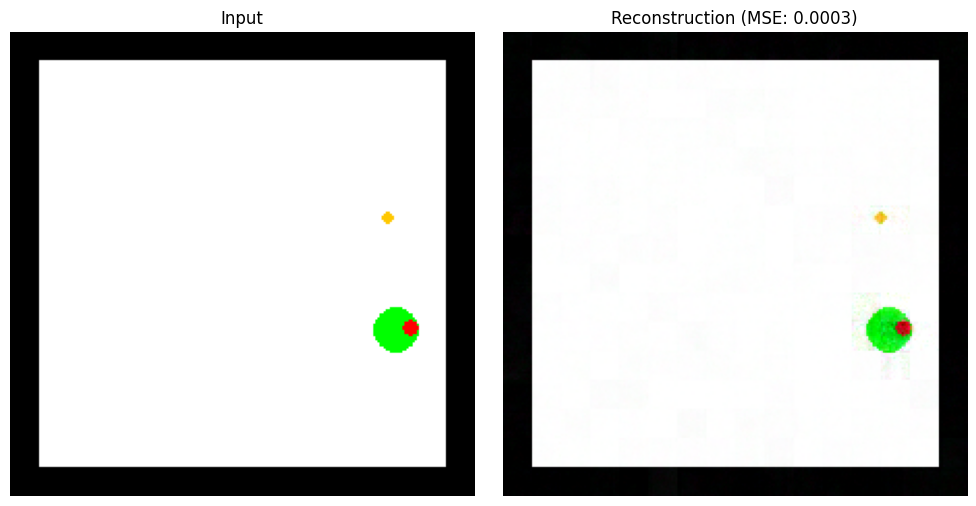


Sample 2 - MSE: 0.000270


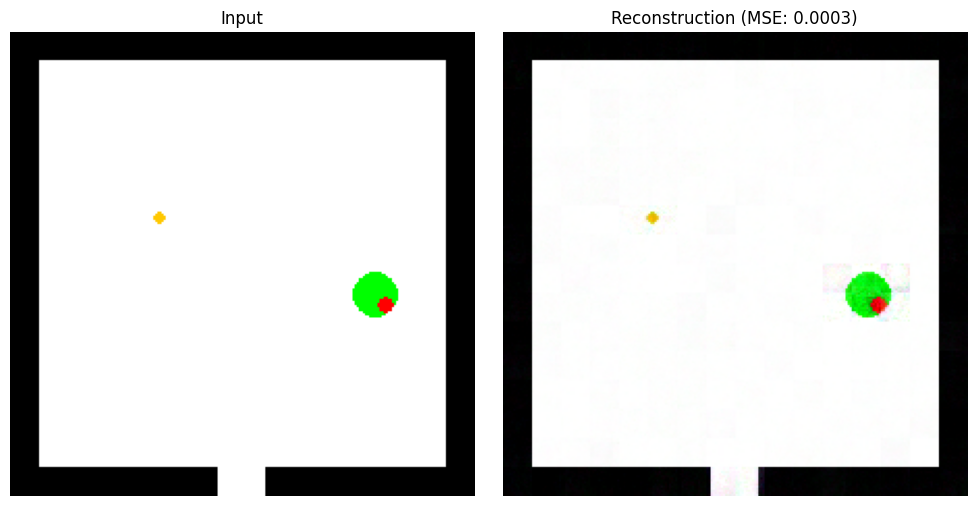


Sample 3 - MSE: 0.000297


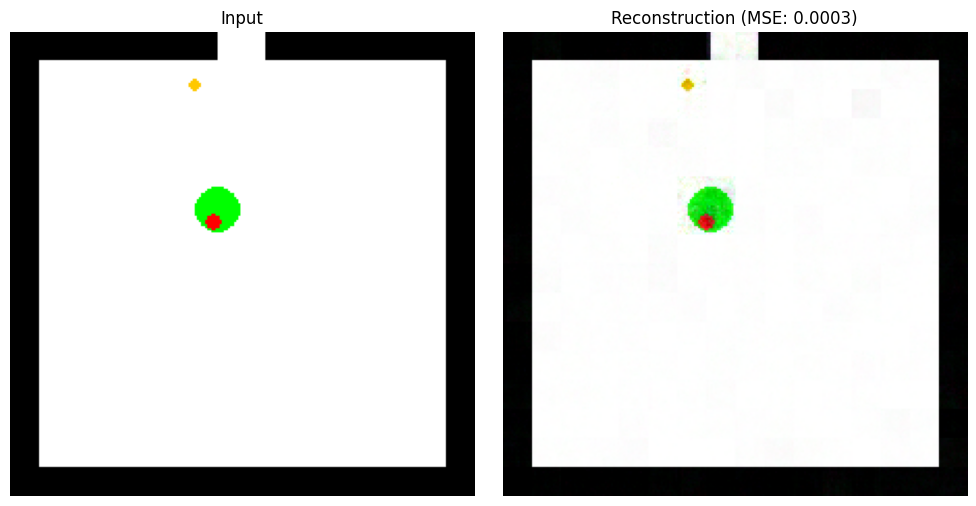

In [7]:
# Generate test images and run through autoencoder 2
print("Testing checkpoint 2: naked_image_bf16")

# Create a base game instance for generating random settings
base_game = discreteGame(BIG_tool_use_advanced_2_5)

# Generate a few test images
for i in range(3):
    G = discreteGame(base_game.random_bare_settings(gameSize=224, max_agent_offset=0.5))
    
    # Convert to tensor
    img = torch.tensor(G.getData(), dtype=torch.bfloat16).unsqueeze(0)
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    
    # Run through autoencoder
    with torch.no_grad():
        recon = autoencoder2(img)
    
    # Compute reconstruction error
    mse = ((img.float() - recon.float()) ** 2).mean().item()
    
    print(f"\nSample {i+1} - MSE: {mse:.6f}")
    compare_images(img, recon, titles=('Input', f'Reconstruction (MSE: {mse:.4f})'))

Comparing both autoencoders on the same inputs:


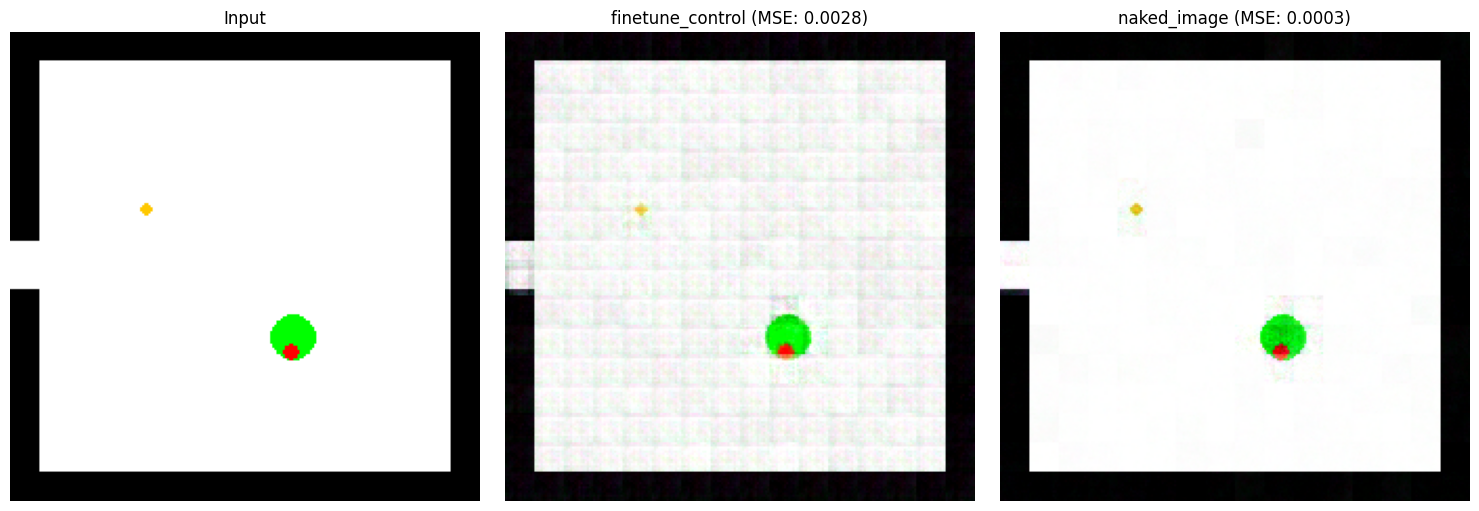

Sample 1: finetune_control MSE=0.002792, naked_image MSE=0.000301



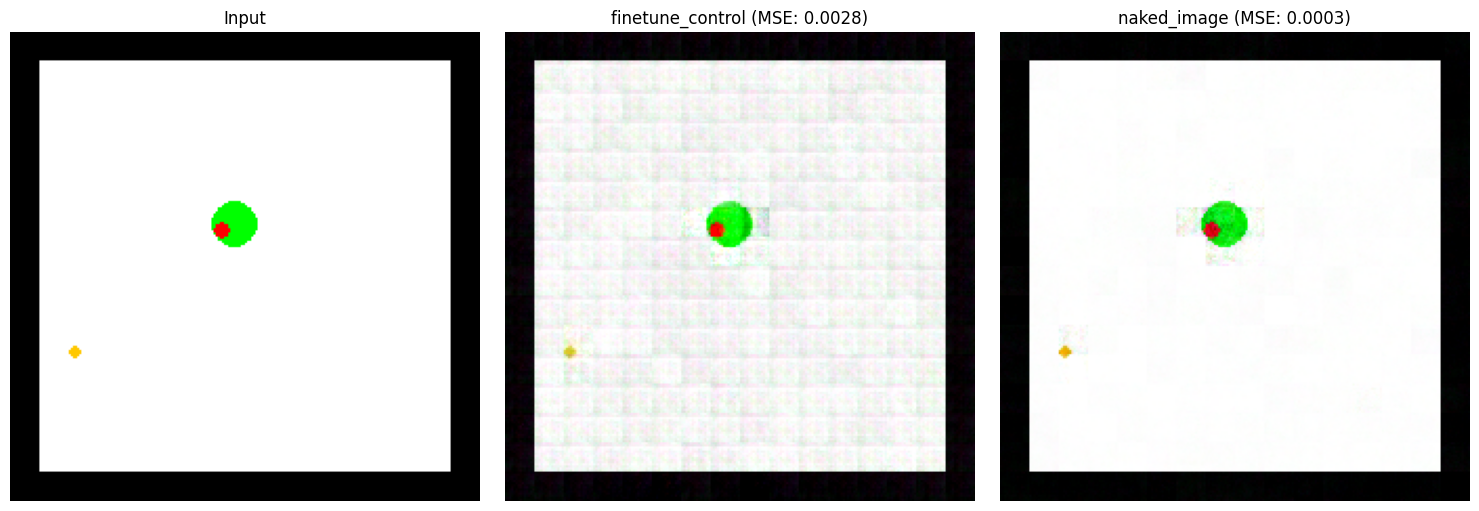

Sample 2: finetune_control MSE=0.002776, naked_image MSE=0.000292



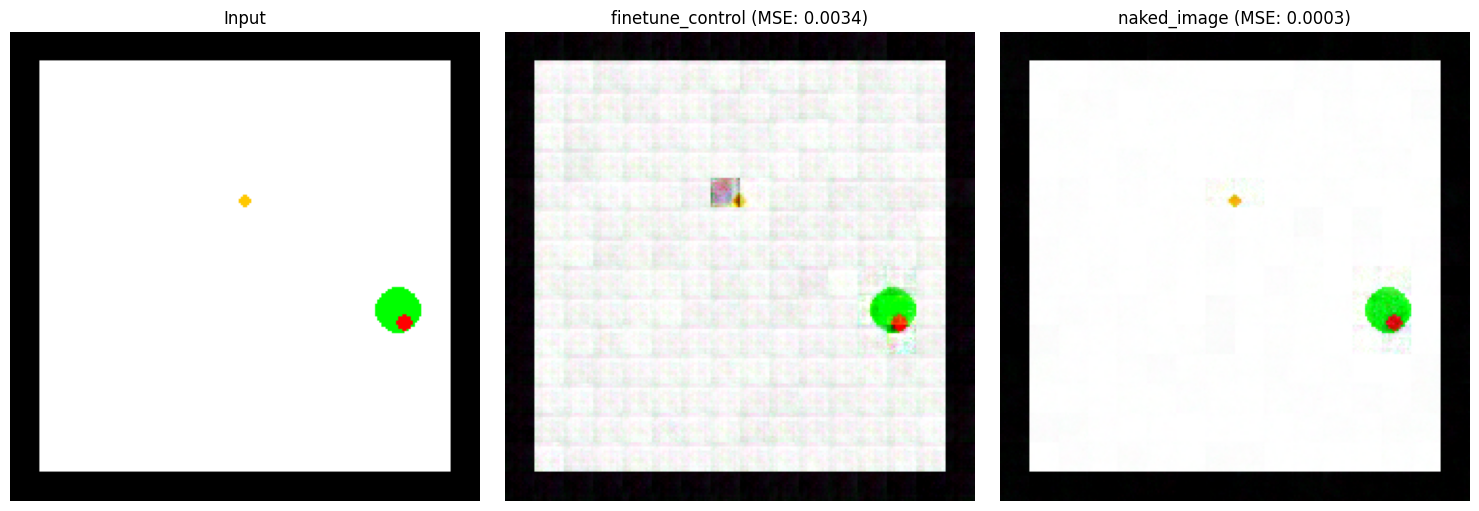

Sample 3: finetune_control MSE=0.003365, naked_image MSE=0.000254



In [8]:
# Side-by-side comparison of both autoencoders on the same input
print("Comparing both autoencoders on the same inputs:")

# Create a base game instance for generating random settings
base_game = discreteGame(BIG_tool_use_advanced_2_5)

for i in range(3):
    G = discreteGame(base_game.random_bare_settings(gameSize=224, max_agent_offset=0.5))
    
    # Convert to tensor
    img = torch.tensor(G.getData(), dtype=torch.bfloat16).unsqueeze(0)
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    
    # Run through both autoencoders
    with torch.no_grad():
        recon1 = autoencoder(img)
        recon2 = autoencoder2(img)
    
    # Compute reconstruction errors
    mse1 = ((img.float() - recon1.float()) ** 2).mean().item()
    mse2 = ((img.float() - recon2.float()) ** 2).mean().item()
    
    # Display all three
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    images = [img, recon1, recon2]
    titles = ['Input', f'finetune_control (MSE: {mse1:.4f})', f'naked_image (MSE: {mse2:.4f})']
    
    for j, (im, title) in enumerate(zip(images, titles)):
        clean = im.detach().cpu().float()
        if len(clean.shape) == 4:
            clean = clean[0]
        right_order = torch.permute(clean, (1, 2, 0))
        array = right_order.numpy().clip(0, 1)
        axes[j].imshow(array)
        axes[j].set_title(title)
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Sample {i+1}: finetune_control MSE={mse1:.6f}, naked_image MSE={mse2:.6f}")
    print()